# This script demonstrates how to build a multi-modal variational autoencoder with vae_tools

In [1]:
#import tensorflow.kera
#print("keras", tensorflow.keras.__version__)
#from tensorflow.keras.layers import Input, Dense, Lambda, Layer
#from tensorflow.keras.datasets import mnist

import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import tensorflow.keras
print("keras", tensorflow.keras.__version__)
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.datasets import mnist
import numpy as np
import numpy
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
import vae_tools.nb_tools
vae_tools.nb_tools.notebook_resize()
# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image


keras version: 2.1.6-tf
tensorflow version: 1.12.0
('matplotlib uses: ', 'module://ipykernel.pylab.backend_inline')
No GPUs available
('keras', '2.1.6-tf')


In [2]:
# Load and investigate data
#data = np.load(file = "/mnt/filedump1/drudolph/old_data/data_steps_1000_color_11_shape_6_reflectivity_2_2019-01-17_15:58:15.npy", encoding='bytes')
#data = np.load(file = "/mnt/filedump1/drudolph/new_data/data_steps_1010_color_2_shape_2_reflectivity_2_2019-01-23_12:58:11.npy", encoding='bytes')

In [3]:
def loader():
    filename = "/mnt/filedump1/drudolph/viable_objects/color_2_shape_2_reflectivity_2_2019-01-25_17:36:39.npy"

    data = np.load(filename, encoding='bytes')

    range_data = data[:, 0]
    camera_data = data[:, 1]
    reflectivity_data = data[:, 2]

    print("range_data", range_data.shape)
    print("camera_data", camera_data.shape)
    print("reflectivity_data", reflectivity_data.shape)
    #return range_data, camera_data, reflectivity_data
    return range_data, camera_data, reflectivity_data
#loader()

In [4]:
#range_data, camera_data, reflectivity_data = loader()
range_data, camera_data, reflectivity_data = loader()


('range_data', (10001, 3))
('camera_data', (10001, 3))
('reflectivity_data', (10001, 3))


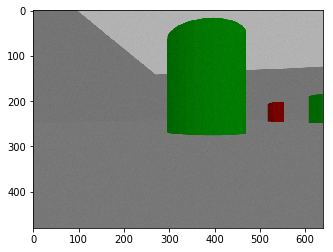

('Cut the image to ', (40, 640, 3))


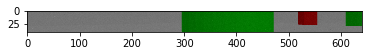

In [5]:
# Get one image and show the result
_data = camera_data[17,1]
resolution = (640,480) # (800,800)
image_data = _data.tobytes() # byte values of the image
image = numpy.asarray(Image.frombytes('RGB', resolution, image_data))
# Show
plt.imshow(image)
plt.show()
print("Cut the image to ", image[220:260,:,:].shape)
plt.imshow(image[220:260,:,:])
plt.show()


In [6]:
# Process the images
window_height = [325,375]
window_height = [240,241]
images = np.zeros(shape=(len(camera_data),resolution[1],resolution[0],3))
images_windowed = np.zeros(shape=(len(camera_data),window_height[1] - window_height[0],resolution[0],3))
images_windowed_flat = np.zeros(shape=(len(camera_data),(window_height[1] - window_height[0]) * resolution[0] * 3))
for idx in range(len(camera_data)):
    #print(camera_data)
    #print(np.frombuffer(camera_data[idx,1], dtype=np.uint8).reshape(resolution[1],resolution[0],3).shape)
    images[idx,:,:,:] = numpy.asarray(Image.frombytes('RGB', resolution, camera_data[idx,1].tobytes()))/255.0
    #images[idx,:,:,:] = np.frombuffer(camera_data[idx,1], dtype=np.uint8).reshape(resolution[0],resolution[1],3)/255.0
    images_windowed[idx,:,:,:] = images[idx,window_height[0]:window_height[1],:,:]
    images_windowed_flat[idx,:] = images_windowed[idx].flatten()
    #images[idx]

X = images_windowed_flat

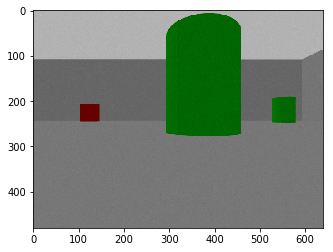

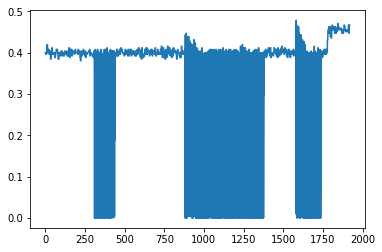

In [7]:
import matplotlib.pyplot as plt
_image = numpy.asarray(Image.frombytes('RGB', resolution, camera_data[52,1].tobytes()))
plt.imshow(_image)
plt.show()
plt.plot(images_windowed_flat[52])
plt.show()

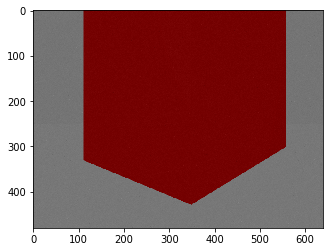

('Cut the image to ', (40, 640, 3))


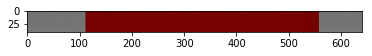

In [8]:
# Sanity Check of the images
resolution = (640,480)
img_idx = 8
img = Image.fromarray((images[img_idx] * 255.0).astype(np.uint8), 'RGB')
#img.show()
image = numpy.asarray(img) / 255.0
# Show
plt.imshow(image)
plt.show()
print("Cut the image to ", image[220:260,:,:].shape)
plt.imshow(image[220:260,:,:])
plt.show()

('min reflection:', 0.0)
('max reflection:', 3.5)
('min ranges:', 0.0)
('max ranges:', 5.0)


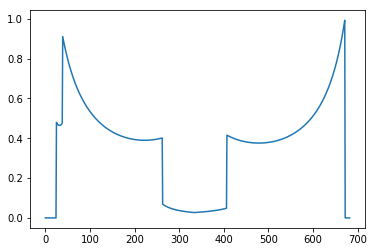

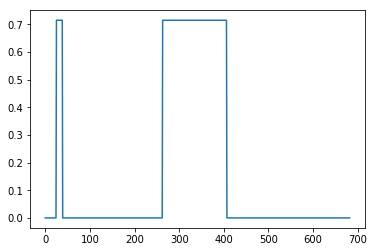

In [9]:
# Process th ranges and reflections
range_data, camera_data, reflectivity_data 
ranges = np.zeros(shape=(len(range_data),len(range_data[0,1])))
reflections = np.zeros(shape=(len(reflectivity_data),len(reflectivity_data[0,1])))
for idx in range(len(range_data)):
    ranges[idx] = range_data[idx,1]
    reflections[idx] = reflectivity_data[idx,1]
# normalization
ranges[ranges == np.inf] = 0
#print(np.min(ranges))
#print(np.max(ranges))
print("min reflection:", np.min(reflections))
print("max reflection:", np.max(reflections))
min_reflections = np.min(reflections)
max_reflections = np.max(reflections)

min_ranges = np.min(ranges)
max_ranges = np.max(ranges)
print("min ranges:", min_ranges)
print("max ranges:", max_ranges)


ranges = ranges - np.min(ranges)
ranges = ranges / np.max(ranges)

#reflections = reflections / np.max([np.max(reflections), -np.min(reflections)])
reflections = reflections - np.min(reflections)
reflections = reflections / np.max(reflections)
#print(np.min(reflections))
#print(np.max(reflections))


plt.plot(ranges[img_idx])
plt.show()
plt.plot(reflections[img_idx])
plt.show()


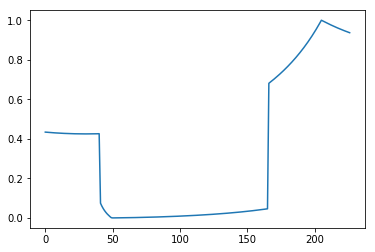

In [10]:
# Cut the measurements
lenght_w = len(ranges[0,:])
lenght_w_2 = int(lenght_w / 2.0)
middle_idx = range(lenght_w_2 - 113, lenght_w_2 + 114)
lenght_w_cut = len(middle_idx)

ranges_cut = ranges[:,middle_idx]
reflections_cut = reflections[:,middle_idx]

# normalize per measurement (This is also important during inference!!!)
if True:
    for idx in range(ranges_cut.shape[0]):
        _range = ranges_cut[idx,:]
        min_val = np.amin(_range[_range != 0.0])
        _range[_range != 0.0] = _range[_range != 0.0] - min_val
        max_val = np.amax(_range)
        _range = _range / max_val
        ranges_cut[idx,:] = _range

ranges, reflections = ranges_cut, reflections_cut
        
data_idx = 17
observation = ranges_cut[0]
plt.plot(observation)
plt.show()


In [11]:
# input image dimensions
img_rows, img_cols, img_chns = window_height[1] - window_height[0], resolution[0], 3
batch_size = 128
img_original_dim = img_rows * img_cols * img_chns
lidar_original_dim = len(ranges[0,:])
intermediate_dim = 256
epochs = 1000
z_dim = 2
beta = 1.

encoder = [[
    Input(shape=(img_original_dim,)),
    Dense(intermediate_dim, activation='relu'),
    Dense(int(intermediate_dim/2), activation='relu')
],
[
    Input(shape=(lidar_original_dim,)),
    Dense(intermediate_dim, activation='relu'),
    Dense(int(intermediate_dim/2), activation='relu')
],
[
    Input(shape=(lidar_original_dim,)),
    Dense(intermediate_dim, activation='relu'),
    Dense(int(intermediate_dim/2), activation='relu')
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(img_original_dim, activation='sigmoid')
],
[
    Dense(int(intermediate_dim/2), activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(lidar_original_dim, activation='sigmoid')
],
[
    Dense(int(intermediate_dim/2), activation='relu'),
    Dense(intermediate_dim, activation='relu'),
    Dense(lidar_original_dim, activation='sigmoid')
]]

# encoder = [[
#     Input(shape=(img_original_dim,)),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(int(intermediate_dim/2), activation='relu')
# ],
# [
#     Input(shape=(lidar_original_dim,)),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(int(intermediate_dim/2), activation='relu')
# ]]

# decoder = [[
#     Dense(int(intermediate_dim/2), activation='relu'),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(img_original_dim, activation='sigmoid')
# ],
# [
#     Dense(int(intermediate_dim/2), activation='relu'),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(lidar_original_dim, activation='sigmoid')
# ]]


# encoder = [[
#     Input(shape=(lidar_original_dim,)),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(int(intermediate_dim/2), activation='relu')
# ]]

# decoder = [[
#     Dense(int(intermediate_dim/2), activation='relu'),
#     Dense(intermediate_dim, activation='relu'),
#     Dense(lidar_original_dim, activation='sigmoid')
# ]]

vae_obj = MmVae(z_dim, encoder, decoder, [img_original_dim, lidar_original_dim, lidar_original_dim], beta = 0.01, beta_is_normalized = True, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='MmVae')
#vae_obj = MmVae(z_dim, encoder, decoder, [lidar_original_dim], beta = beta, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='MmVae')

vae = vae_obj.get_model()
vae.compile(optimizer='adam', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

('A:', [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>], ' is proper subset of B:', [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 227) dtype=float32>])
('A:', [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>], ' is proper subset of B:', [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 227) dtype=float32>])
('A:', [<tf.Tensor 'input_2:0' shape=(?, 227) dtype=float32>], ' is proper subset of B:', [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 227) dtype=float32>])
('A:', [<tf.Tensor 'input_2:0' shape=(?, 227) dtype=float32>], ' is proper subset of B:', [<tf.Tensor 'input_2:0' shape=(?, 227) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 227) dtype=float32>])
('A:', [<tf.Tensor 'input_3:0' shape=(?, 227) dtype=float32>], ' is proper subset of B:', [<tf.Tensor 'input_1:0' shape=(?, 1920) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 227) dtype=float

In [12]:
x_train = [images_windowed_flat, ranges, reflections]
# x_train = [images_windowed_flat, ranges]
# x_train = [images_windowed_flat]
# x_train = [reflections]

# Store the losses to a history object for plotting
losses_cb = vae_tools.callbacks.Losses(data = x_train)
# Train
vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose = 1,
            callbacks=[losses_cb])

Epoch 1/1000
10001/10001 [==============================] - 6s 622us/step - loss: 503.6460
Epoch 2/1000
10001/10001 [==============================] - 3s 260us/step - loss: 391.7677
Epoch 3/1000
10001/10001 [==============================] - 3s 258us/step - loss: 369.4977
Epoch 4/1000
10001/10001 [==============================] - 3s 258us/step - loss: 364.7968
Epoch 5/1000
10001/10001 [==============================] - 3s 259us/step - loss: 362.1931
Epoch 6/1000
10001/10001 [==============================] - 3s 258us/step - loss: 360.9110
Epoch 7/1000
10001/10001 [==============================] - 3s 258us/step - loss: 360.6842
Epoch 8/1000
10001/10001 [==============================] - 3s 268us/step - loss: 359.2317
Epoch 9/1000
10001/10001 [==============================] - 3s 291us/step - loss: 355.7995
Epoch 10/1000
10001/10001 [==============================] - 3s 275us/step - loss: 345.2110
Epoch 11/1000
10001/10001 [==============================] - 3s 285us/step - loss: 339.34

10001/10001 [==============================] - 3s 254us/step - loss: 305.0010
Epoch 91/1000
10001/10001 [==============================] - 3s 253us/step - loss: 304.3392
Epoch 92/1000
10001/10001 [==============================] - 3s 255us/step - loss: 304.3932
Epoch 93/1000
10001/10001 [==============================] - 3s 255us/step - loss: 304.5641
Epoch 94/1000
10001/10001 [==============================] - 3s 252us/step - loss: 305.5953
Epoch 95/1000
10001/10001 [==============================] - 3s 255us/step - loss: 305.0348
Epoch 96/1000
10001/10001 [==============================] - 3s 252us/step - loss: 304.8992
Epoch 97/1000
10001/10001 [==============================] - 3s 256us/step - loss: 304.5742
Epoch 98/1000
10001/10001 [==============================] - 3s 254us/step - loss: 306.4030
Epoch 99/1000
10001/10001 [==============================] - 3s 254us/step - loss: 305.3622
Epoch 100/1000
10001/10001 [==============================] - 3s 253us/step - loss: 304.2243
E

10001/10001 [==============================] - 3s 252us/step - loss: 301.2003
Epoch 179/1000
10001/10001 [==============================] - 3s 252us/step - loss: 302.3683
Epoch 180/1000
10001/10001 [==============================] - 3s 256us/step - loss: 301.7501
Epoch 181/1000
10001/10001 [==============================] - 3s 253us/step - loss: 300.5556
Epoch 182/1000
10001/10001 [==============================] - 3s 253us/step - loss: 301.4933
Epoch 183/1000
10001/10001 [==============================] - 3s 254us/step - loss: 300.8178
Epoch 184/1000
10001/10001 [==============================] - 3s 257us/step - loss: 302.0255
Epoch 185/1000
10001/10001 [==============================] - 3s 255us/step - loss: 301.7651
Epoch 186/1000
10001/10001 [==============================] - 3s 252us/step - loss: 306.2320
Epoch 187/1000
10001/10001 [==============================] - 3s 254us/step - loss: 302.3192
Epoch 188/1000
10001/10001 [==============================] - 3s 255us/step - loss: 3

10001/10001 [==============================] - 3s 256us/step - loss: 299.7638
Epoch 267/1000
10001/10001 [==============================] - 3s 254us/step - loss: 301.0445
Epoch 268/1000
10001/10001 [==============================] - 3s 252us/step - loss: 299.0394
Epoch 269/1000
10001/10001 [==============================] - 3s 254us/step - loss: 298.9952
Epoch 270/1000
10001/10001 [==============================] - 3s 257us/step - loss: 298.4947
Epoch 271/1000
10001/10001 [==============================] - 3s 251us/step - loss: 300.0525
Epoch 272/1000
10001/10001 [==============================] - 3s 253us/step - loss: 300.6355
Epoch 273/1000
10001/10001 [==============================] - 3s 254us/step - loss: 298.7784
Epoch 274/1000
10001/10001 [==============================] - 3s 254us/step - loss: 298.4583
Epoch 275/1000
10001/10001 [==============================] - 3s 253us/step - loss: 298.7339
Epoch 276/1000
10001/10001 [==============================] - 3s 254us/step - loss: 2

10001/10001 [==============================] - 3s 252us/step - loss: 297.2582
Epoch 355/1000
10001/10001 [==============================] - 3s 252us/step - loss: 298.0414
Epoch 356/1000
10001/10001 [==============================] - 3s 253us/step - loss: 297.3070
Epoch 357/1000
10001/10001 [==============================] - 3s 256us/step - loss: 298.0997
Epoch 358/1000
10001/10001 [==============================] - 3s 254us/step - loss: 297.8112
Epoch 359/1000
10001/10001 [==============================] - 3s 252us/step - loss: 299.2394
Epoch 360/1000
10001/10001 [==============================] - 3s 254us/step - loss: 299.0452
Epoch 361/1000
10001/10001 [==============================] - 3s 252us/step - loss: 297.6119
Epoch 362/1000
10001/10001 [==============================] - 3s 251us/step - loss: 298.5665
Epoch 363/1000
10001/10001 [==============================] - 3s 252us/step - loss: 298.2495
Epoch 364/1000
10001/10001 [==============================] - 3s 255us/step - loss: 2

10001/10001 [==============================] - 3s 253us/step - loss: 296.7042
Epoch 443/1000
10001/10001 [==============================] - 3s 252us/step - loss: 295.7718
Epoch 444/1000
10001/10001 [==============================] - 3s 253us/step - loss: 296.6777
Epoch 445/1000
10001/10001 [==============================] - 3s 257us/step - loss: 296.4230
Epoch 446/1000
10001/10001 [==============================] - 3s 253us/step - loss: 296.1408
Epoch 447/1000
10001/10001 [==============================] - 3s 254us/step - loss: 296.6385
Epoch 448/1000
10001/10001 [==============================] - 3s 252us/step - loss: 299.3912
Epoch 449/1000
10001/10001 [==============================] - 3s 251us/step - loss: 297.1155
Epoch 450/1000
10001/10001 [==============================] - 3s 252us/step - loss: 296.5277
Epoch 451/1000
10001/10001 [==============================] - 3s 254us/step - loss: 295.6776
Epoch 452/1000
10001/10001 [==============================] - 3s 252us/step - loss: 2

10001/10001 [==============================] - 3s 253us/step - loss: 298.0011
Epoch 531/1000
10001/10001 [==============================] - 3s 251us/step - loss: 298.3463
Epoch 532/1000
10001/10001 [==============================] - 3s 254us/step - loss: 297.8488
Epoch 533/1000
10001/10001 [==============================] - 3s 253us/step - loss: 297.4013
Epoch 534/1000
10001/10001 [==============================] - 3s 252us/step - loss: 297.3664
Epoch 535/1000
10001/10001 [==============================] - 3s 251us/step - loss: 297.8506
Epoch 536/1000
10001/10001 [==============================] - 3s 255us/step - loss: 297.0431
Epoch 537/1000
10001/10001 [==============================] - 3s 252us/step - loss: 296.3725
Epoch 538/1000
10001/10001 [==============================] - 3s 255us/step - loss: 296.3409
Epoch 539/1000
10001/10001 [==============================] - 3s 259us/step - loss: 297.5107
Epoch 540/1000
10001/10001 [==============================] - 3s 254us/step - loss: 2

10001/10001 [==============================] - 3s 253us/step - loss: 296.0708
Epoch 619/1000
10001/10001 [==============================] - 3s 257us/step - loss: 295.2618
Epoch 620/1000
10001/10001 [==============================] - 3s 255us/step - loss: 296.1201
Epoch 621/1000
10001/10001 [==============================] - 3s 250us/step - loss: 296.2670
Epoch 622/1000
10001/10001 [==============================] - 3s 256us/step - loss: 296.6142
Epoch 623/1000
10001/10001 [==============================] - 3s 254us/step - loss: 297.3825
Epoch 624/1000
10001/10001 [==============================] - 3s 254us/step - loss: 299.9768
Epoch 625/1000
10001/10001 [==============================] - 3s 255us/step - loss: 300.1247
Epoch 626/1000
10001/10001 [==============================] - 3s 254us/step - loss: 299.5826
Epoch 627/1000
10001/10001 [==============================] - 3s 255us/step - loss: 297.7005
Epoch 628/1000
10001/10001 [==============================] - 3s 252us/step - loss: 2

10001/10001 [==============================] - 3s 254us/step - loss: 294.8344
Epoch 707/1000
10001/10001 [==============================] - 3s 256us/step - loss: 294.6443
Epoch 708/1000
10001/10001 [==============================] - 3s 250us/step - loss: 294.5343
Epoch 709/1000
10001/10001 [==============================] - 3s 253us/step - loss: 294.8728
Epoch 710/1000
10001/10001 [==============================] - 3s 256us/step - loss: 295.9864
Epoch 711/1000
10001/10001 [==============================] - 3s 253us/step - loss: 295.8262
Epoch 712/1000
10001/10001 [==============================] - 3s 252us/step - loss: 294.3870
Epoch 713/1000
10001/10001 [==============================] - 3s 256us/step - loss: 294.0957
Epoch 714/1000
10001/10001 [==============================] - 3s 254us/step - loss: 294.5869
Epoch 715/1000
10001/10001 [==============================] - 3s 255us/step - loss: 294.4930
Epoch 716/1000
10001/10001 [==============================] - 3s 253us/step - loss: 2

10001/10001 [==============================] - 3s 254us/step - loss: 294.2294
Epoch 795/1000
10001/10001 [==============================] - 3s 253us/step - loss: 294.1087
Epoch 796/1000
10001/10001 [==============================] - 3s 256us/step - loss: 294.3280
Epoch 797/1000
10001/10001 [==============================] - 3s 253us/step - loss: 293.8929
Epoch 798/1000
10001/10001 [==============================] - 3s 252us/step - loss: 293.9896
Epoch 799/1000
10001/10001 [==============================] - 3s 256us/step - loss: 293.3282
Epoch 800/1000
10001/10001 [==============================] - 3s 253us/step - loss: 293.6574
Epoch 801/1000
10001/10001 [==============================] - 3s 255us/step - loss: 293.7013
Epoch 802/1000
10001/10001 [==============================] - 3s 251us/step - loss: 294.3567
Epoch 803/1000
10001/10001 [==============================] - 3s 252us/step - loss: 295.0354
Epoch 804/1000
10001/10001 [==============================] - 3s 252us/step - loss: 2

10001/10001 [==============================] - 3s 254us/step - loss: 293.1466
Epoch 883/1000
10001/10001 [==============================] - 3s 253us/step - loss: 293.0841
Epoch 884/1000
10001/10001 [==============================] - 3s 254us/step - loss: 293.4248
Epoch 885/1000
10001/10001 [==============================] - 3s 253us/step - loss: 293.2454
Epoch 886/1000
10001/10001 [==============================] - 3s 251us/step - loss: 293.7058
Epoch 887/1000
10001/10001 [==============================] - 3s 254us/step - loss: 293.3722
Epoch 888/1000
10001/10001 [==============================] - 3s 255us/step - loss: 293.1256
Epoch 889/1000
10001/10001 [==============================] - 3s 254us/step - loss: 292.9791
Epoch 890/1000
10001/10001 [==============================] - 3s 253us/step - loss: 293.1200
Epoch 891/1000
10001/10001 [==============================] - 3s 254us/step - loss: 292.8128
Epoch 892/1000
10001/10001 [==============================] - 3s 254us/step - loss: 2

10001/10001 [==============================] - 3s 254us/step - loss: 294.5485
Epoch 971/1000
10001/10001 [==============================] - 3s 255us/step - loss: 294.6495
Epoch 972/1000
10001/10001 [==============================] - 3s 256us/step - loss: 294.1491
Epoch 973/1000
10001/10001 [==============================] - 3s 254us/step - loss: 293.5745
Epoch 974/1000
10001/10001 [==============================] - 3s 253us/step - loss: 294.2247
Epoch 975/1000
10001/10001 [==============================] - 3s 255us/step - loss: 293.3866
Epoch 976/1000
10001/10001 [==============================] - 3s 255us/step - loss: 292.6354
Epoch 977/1000
10001/10001 [==============================] - 3s 254us/step - loss: 292.8136
Epoch 978/1000
10001/10001 [==============================] - 3s 254us/step - loss: 293.4406
Epoch 979/1000
10001/10001 [==============================] - 3s 254us/step - loss: 293.6922
Epoch 980/1000
10001/10001 [==============================] - 3s 254us/step - loss: 2

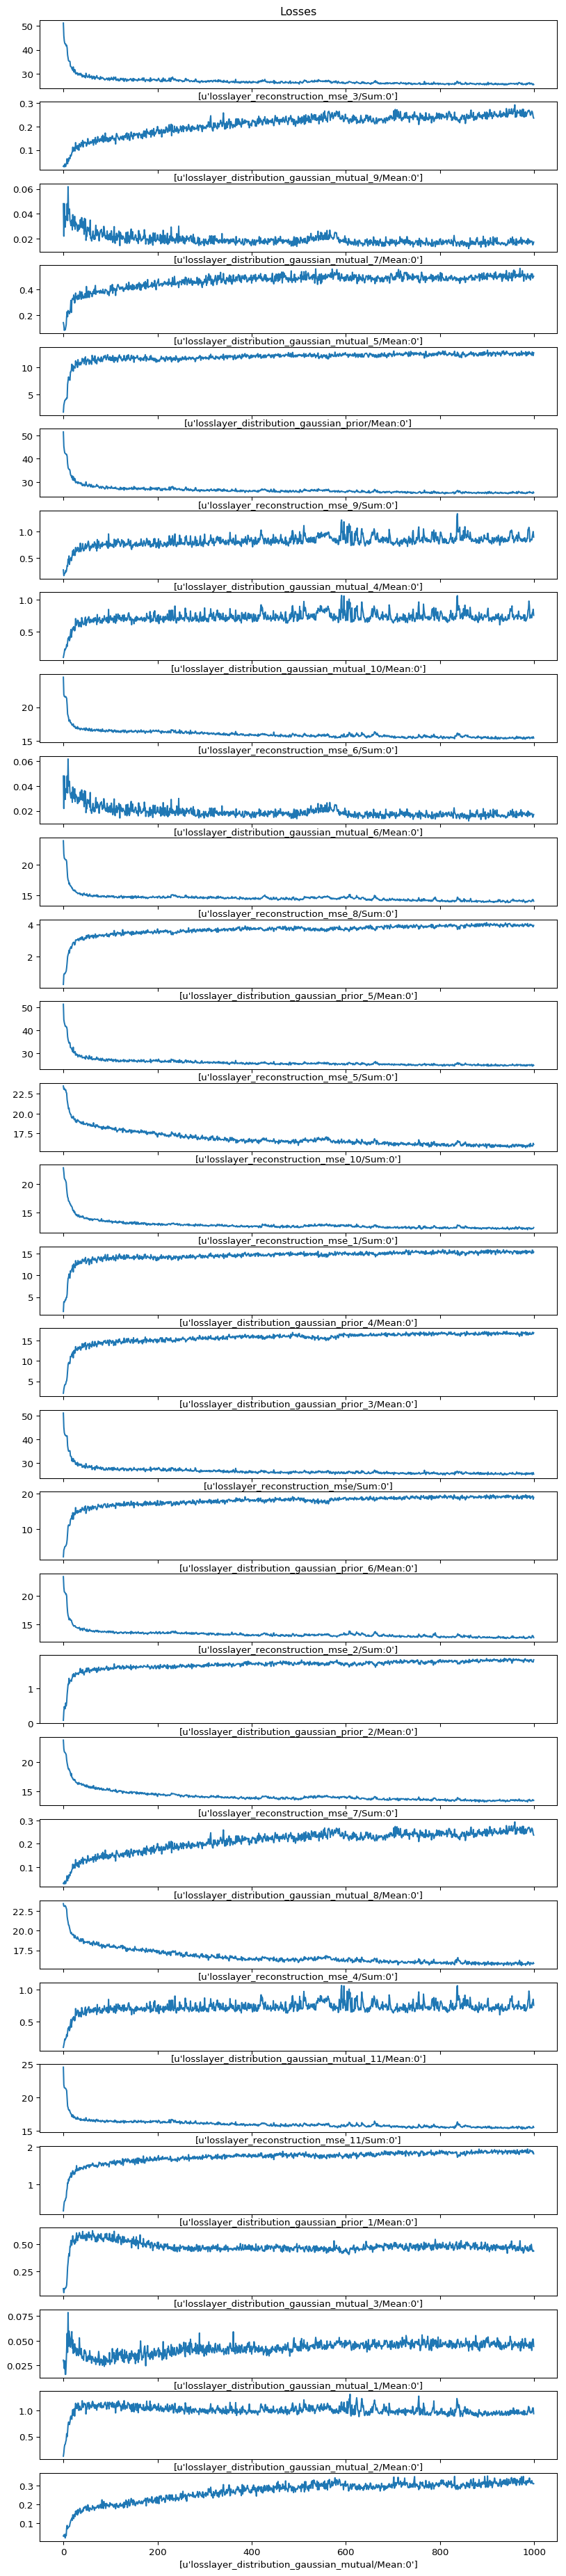

In [13]:
# Show the losses
import matplotlib
import matplotlib.pyplot as plt
num_losses = len(losses_cb.history.values())
f, axs = plt.subplots(num_losses, 1, sharex=True, figsize=[10,50], dpi=96)
axs[0].set_title("Losses")
for idx in range(num_losses):
    axs[idx].plot(list(losses_cb.history.values())[idx])
    axs[idx].set_xlabel([list(losses_cb.history.keys())[idx]])
plt.show()

In [14]:
# Store the models
vae_obj.store_model_powerset(prefix = 'models/enc_mean_xwv_', model_inputs = vae_obj.encoder_inputs,
                     get_model_callback = vae_obj.get_encoder_mean)
vae_obj.store_model_powerset(prefix = 'models/enc_logvar_xwv_', model_inputs = vae_obj.encoder_inputs,
                     get_model_callback = vae_obj.get_encoder_logvar)
vae_obj.store_model(name = 'models/decoder_xwv', model = vae_obj.get_decoder(), overwrite = True)


# store preprocess data
import json
preprocessed_data = {'min_reflections':min_reflections, 
                     'max_reflections':max_reflections, 
                     'min_ranges':min_ranges, 
                     'max_ranges':max_ranges,
                     'image_window_height':window_height,
                     'image_resolution':resolution,
                     'img_original_dim':img_original_dim,
                     'lidar_original_dim':lidar_original_dim, 
                     'intermediate_dim':intermediate_dim}
        
with open('models/vae_sensor_parameter.json', 'w') as fp:
    json.dump(preprocessed_data, fp)

# Load the models
encoder_mean_models, bitmask =  vae_obj.load_model_powerset(prefix = 'models/enc_mean_xwv_', num_elements = len(vae_obj.encoder_inputs))
encoder_logvar_models, bitmask =  vae_obj.load_model_powerset(prefix = 'models/enc_logvar_xwv_', num_elements = len(vae_obj.encoder_inputs))
decoder_model =  vae_obj.load_model(name = 'models/decoder_xwv')


Saved model models/enc_mean_xwv_100 to disk
Saved weights of model models/enc_mean_xwv_100 to disk
Saved model models/enc_mean_xwv_010 to disk
Saved weights of model models/enc_mean_xwv_010 to disk
Saved model models/enc_mean_xwv_110 to disk
Saved weights of model models/enc_mean_xwv_110 to disk
Saved model models/enc_mean_xwv_001 to disk
Saved weights of model models/enc_mean_xwv_001 to disk
Saved model models/enc_mean_xwv_101 to disk
Saved weights of model models/enc_mean_xwv_101 to disk
Saved model models/enc_mean_xwv_011 to disk
Saved weights of model models/enc_mean_xwv_011 to disk
Saved model models/enc_mean_xwv_111 to disk
Saved weights of model models/enc_mean_xwv_111 to disk
Saved model models/enc_logvar_xwv_100 to disk
Saved weights of model models/enc_logvar_xwv_100 to disk
Saved model models/enc_logvar_xwv_010 to disk
Saved weights of model models/enc_logvar_xwv_010 to disk
Saved model models/enc_logvar_xwv_110 to disk
Saved weights of model models/enc_logvar_xwv_110 to dis

In [15]:
import vae_tools.metrics
X,W,V = images_windowed_flat, ranges, reflections
data_idx = 17

# Get the encoding of x (100 = 1, but we start at 0 => 100 = 0)
encoder_idx = 0
#vae_tools.viz.plot_model(encoder_mean_models[encoder_idx])
obs = X[[data_idx],:]
print(obs.shape)
print("Prediction of x", str(encoder_mean_models[encoder_idx].predict(obs)))

# Get the encoding of x and w (110 = 3, but we start at 0 => 110 = 2)
encoder_idx = 2
#vae_tools.viz.plot_model(encoder_mean_models[encoder_idx])
obs = [X[[data_idx],:],W[[data_idx],:]]
print("Prediction of x & w", str(encoder_mean_models[encoder_idx].predict(obs)))

# Get the D_KL of x, v, and w (111 = 7, but we start at 0 => 111 = 6)
encoder_idx = 6
#vae_tools.viz.plot_model(encoder_models[encoder_idx])
obs = [X[[data_idx],:],W[[data_idx],:],V[[data_idx],:]]
mean = encoder_mean_models[encoder_idx].predict(obs)
logvar = encoder_logvar_models[encoder_idx].predict(obs)
print("D_KL of predicting x,w,v", str(np.sum(vae_tools.metrics.kl_loss_n(mean, logvar))))

# Get the D_KL of x, v, and w (111 = 7, but we start at 0 => 111 = 6)
encoder_idx = 6
#vae_tools.viz.plot_model(encoder_models[encoder_idx])
obs = [X[[data_idx],:],W[[data_idx],:],V[[data_idx],:]]
mean = encoder_mean_models[encoder_idx].predict(obs)
logvar = encoder_logvar_models[encoder_idx].predict(obs)
mean = np.array([[6.3269215, 8.964689]])
logvar = np.array([[-177.66656,  124.51832]])
d_kl = np.sum(vae_tools.metrics.kl_loss_n(mean, logvar))
print("mean:", mean)
print("logvar:", logvar)
print("d_kl:", d_kl)
print(np.sum(- .5 * (1 + logvar - 0 - ((np.exp(logvar) + np.square(mean - 0)) / np.exp(0)))))
print("vae_tools.metric.kl_loss_n:", vae_tools.metrics.kl_loss_n(mean, logvar))
reconstruction = decoder_model.predict(mean)
x_rec_loss = vae_tools.metrics.binary_cross_entropy(reconstruction[0], np.clip(obs[0],0.001,0.999))
w_rec_loss = vae_tools.metrics.binary_cross_entropy(reconstruction[1], np.clip(obs[1],0.001,0.999))
v_rec_loss = vae_tools.metrics.binary_cross_entropy(reconstruction[2], np.clip(obs[2],0.001,0.999))
print("ELBO: ", d_kl + x_rec_loss + w_rec_loss + v_rec_loss)

(1, 1920)
('Prediction of x', '[[-0.10306937  0.46787256]]')
('Prediction of x & w', '[[-0.1111841   0.48976678]]')
('D_KL of predicting x,w,v', '1.7503557')
('mean:', array([[6.3269215, 8.964689 ]]))
('logvar:', array([[-177.66656,  124.51832]]))
('d_kl:', 5.978459288814316e+53)
5.978459288814316e+53
('vae_tools.metric.kl_loss_n:', array([[1.08348248e+02, 5.97845929e+53]]))
('ELBO: ', 5.978459288814316e+53)


In [16]:
mean = np.array([[-7.67008781e-01,  3.94721738e+2]])
out = decoder_model.predict(mean)
out

[array([[0.4988092, 1.       , 1.       , ..., 0.9999995, 0.       ,
         0.       ]], dtype=float32),
 array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 3.66120646e-03, 2.62991486e-11, 2.63987806e-13,
         6.81730505e-11, 2.76568386e-23, 1.04590274e-29, 4.78314012e-31,
         2.88902095e-36, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.000000

In [17]:
mean1 = np.array([[-200.76700878, -10.00823164]])
log_var1 = np.array([[ 121.80058289, -360.97341919]])
log_var1 = np.array([[ -10.86702728, 10.8711853]])

mean2 = 0.
log_var2 = 0.

- .5 * (1 + log_var1 - log_var2 - ((np.exp(log_var1) + np.square(mean1 - mean2)) / np.exp(log_var2)))

array([[20158.62943041, 26362.9290647 ]])

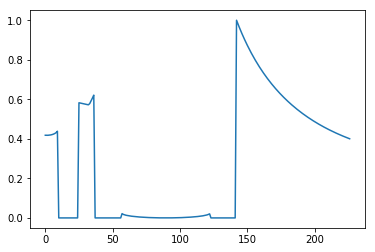

('Embedding (mean) of w at ', 30, ' :', '[[-0.07494576  1.1136482 ]]')
('Embedding (var)  of w at ', 30, ' :', '[[-2.198548  -1.8813832]]')
Reconstruction of w's embedding


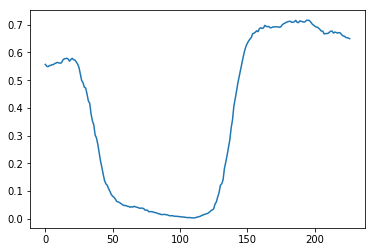

('Embedding (mean) of w at ', 0, ' :', '[[-0.07494576  1.1136482 ]]')
('Embedding (var)  of w at ', 0, ' :', '[[-2.198548  -1.8813832]]')
('Embedding (mean) of w at ', 1, ' :', '[[-0.14006716  0.95012826]]')
('Embedding (var)  of w at ', 1, ' :', '[[-2.0845869 -1.9363607]]')
('Embedding (mean) of w at ', 2, ' :', '[[-0.19377297  0.8885311 ]]')
('Embedding (var)  of w at ', 2, ' :', '[[-2.1024418 -2.0636163]]')
('Embedding (mean) of w at ', 3, ' :', '[[-0.22247809  0.868318  ]]')
('Embedding (var)  of w at ', 3, ' :', '[[-2.085901 -2.073347]]')
('Embedding (mean) of w at ', 4, ' :', '[[-0.24585566  0.8610341 ]]')
('Embedding (var)  of w at ', 4, ' :', '[[-2.046007  -2.0637271]]')
('Embedding (mean) of w at ', 5, ' :', '[[-0.26256335  0.85874563]]')
('Embedding (var)  of w at ', 5, ' :', '[[-2.0151095 -2.0528827]]')
('Embedding (mean) of w at ', 6, ' :', '[[-0.27366576  0.8581141 ]]')
('Embedding (var)  of w at ', 6, ' :', '[[-1.9941142 -2.0438216]]')
('Embedding (mean) of w at ', 7, ' :

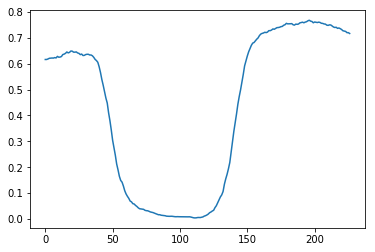

In [18]:
data_idx = 17
observation = [W[[data_idx],:]]
plt.plot(observation[0][0])
plt.show()
# Get the encoding for ranges : w (010 = 2, but we start at 0 => 110 = 1)
encoder_idx = 1
#vae_tools.viz.plot_model(encoder_mean_models[encoder_idx])
mean = encoder_mean_models[encoder_idx].predict(observation)
logvar = encoder_logvar_models[encoder_idx].predict(observation)
print("Embedding (mean) of w at ", idx, " :", str(mean))
print("Embedding (var)  of w at ", idx, " :", str(logvar))
print("Reconstruction of w's embedding")
reconstruction = np.clip(decoder_model.predict(mean)[1],0.001,0.999)
plt.plot(reconstruction[0])
plt.show()

# reencode for some steps
for idx in range(20):
    print("Embedding (mean) of w at ", idx, " :", str(mean))
    print("Embedding (var)  of w at ", idx, " :", str(logvar))
    logvar = encoder_logvar_models[encoder_idx].predict(reconstruction)
    mean = encoder_mean_models[encoder_idx].predict(reconstruction)
    reconstruction = np.clip(decoder_model.predict(mean)[1],0.001,0.999)
plt.plot(reconstruction[0])
plt.show()